In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
def train_val_generators(training_dir, validation_dir):

    train_datagen = ImageDataGenerator(rescale=1./255.)

    train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                        batch_size=64,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

    validation_datagen = ImageDataGenerator(rescale=1./255.)

    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                  batch_size=64,
                                                                  class_mode='categorical',
                                                                  target_size=(150, 150))

    return train_generator, validation_generator

In [10]:
training_dir = '/kaggle/input/faceskin-dataset/Acne/Train'
validation_dir = '/kaggle/input/faceskin-dataset/Acne/Validation'
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 10789 images belonging to 3 classes.
Found 5176 images belonging to 3 classes.


In [11]:
mobilenet =  MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in mobilenet.layers:
    layer.trainable = False

model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
169/169 [==============================] - 179s 1s/step - loss: 0.0898 - accuracy: 0.9615 - val_loss: 0.0251 - val_accuracy: 0.9874
Epoch 2/10
169/169 [==============================] - 176s 1s/step - loss: 0.0411 - accuracy: 0.9829 - val_loss: 0.0200 - val_accuracy: 0.9915
Epoch 3/10
169/169 [==============================] - 176s 1s/step - loss: 0.0282 - accuracy: 0.9893 - val_loss: 0.0336 - val_accuracy: 0.9892
Epoch 4/10
169/169 [==============================] - 176s 1s/step - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.0204 - val_accuracy: 0.9915
Epoch 5/10
169/169 [==============================] - 202s 1s/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.0292 - val_accuracy: 0.9913
Epoch 6/10
169/169 [==============================] - 172s 1s/step - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.0217 - val_accuracy: 0.9915
Epoch 7/10
169/169 [==============================] - 199s 1s/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0235 - val_accuracy: 0.9925

In [14]:

true_classes = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())

predicted_classes = model.predict(validation_generator)
predicted_classes = np.argmax(predicted_classes, axis=1)

precision, recall, f1_score, support = precision_recall_fscore_support(
    true_classes, predicted_classes, average='weighted', labels=np.unique(predicted_classes))

accuracy = accuracy_score(true_classes, predicted_classes)

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1_score)
print('Accuracy:', accuracy)

81/81 [==============================] - 53s 645ms/step
Precision: 0.8544121035921118
Recall: 0.8545208655332303
F1-Score: 0.8544454135005713
Accuracy: 0.8545208655332303


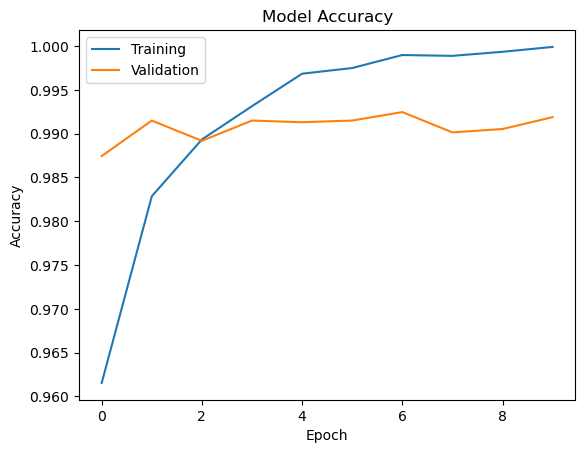

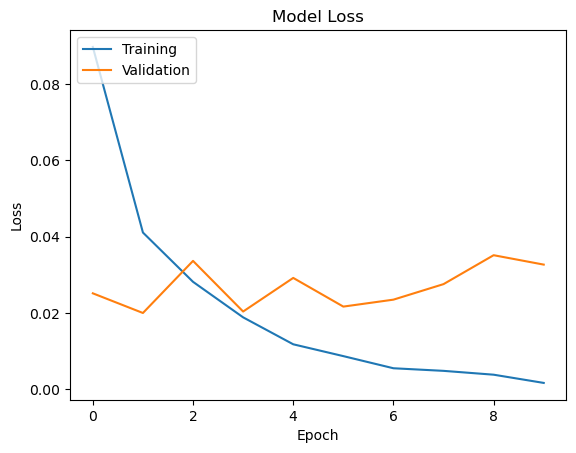

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('ImageClassificationAcne.h5')

In [ ]:
model = tf.keras.models.load_model('/kaggle/working/ImageClassificationAcne.h5')
tf.saved_model.save(model, 'saved_model_path')

# Convert the SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model_path')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
import numpy as np
import os
import shutil
from tensorflow.keras.utils import load_img, img_to_array
from IPython.display import Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Mengunggah file gambar
uploaded_file = input("Masukkan path file gambar: ")
uploaded_file_name = os.path.basename(uploaded_file)

# Salin file gambar ke direktori saat ini
shutil.copyfile(uploaded_file, uploaded_file_name)

# Membaca gambar menggunakan PIL
img = PILImage.open(uploaded_file_name)
img = img.resize((150, 150))  # Mengubah ukuran gambar menjadi (150, 150)

plt.imshow(img)
plt.axis('off')
plt.show()

# Mengonversi gambar menjadi array dan melakukan normalisasi
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

# Melakukan prediksi gambar
predictions = model.predict(x)

# Menentukan label kelas
class_labels = ['Jerawat', 'Bersih', 'Komedo']
predicted_class = class_labels[np.argmax(predictions)]
confidence = np.max(predictions) * 100

# Menampilkan hasil prediksi
print(f"{uploaded_file_name} terdeteksi sebagai: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

# Menghapus file yang diunggah
os.remove(uploaded_file_name)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso